In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset                     # For training
from torch.optim.lr_scheduler import LambdaLR, StepLR   # For warmup and LR scheduling
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt
import numpy as np


In [5]:

# Image Augmentation
aug_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.01, 0.01)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

org_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Declare the original
aug_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=aug_transform)
org_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=org_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=False, transform = org_transform)

# Concatenate both datasets
concat_dataset = ConcatDataset([aug_train_dataset, org_train_dataset])

train_loader = DataLoader(concat_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Reduce the datasets for development
subset_train_dataset = Subset(concat_dataset, list(range(10000)))
subset_test_dataset = Subset(test_dataset, list(range(2000)))

# Data loader declaration
subset_train_loader = DataLoader(subset_train_dataset, batch_size=128, shuffle=True)
subset_test_loader = DataLoader(subset_test_dataset, batch_size=128, shuffle=True)

len(subset_train_dataset)

10000

(-0.5, 31.5, 31.5, -0.5)

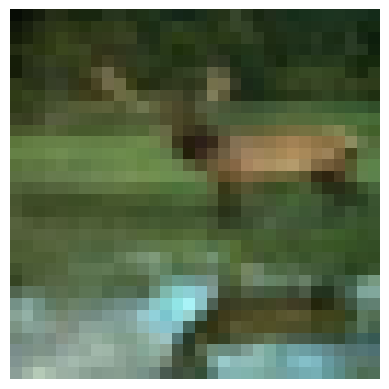

In [6]:
example = next(iter(train_loader))

example = (example[0][0] + 1) / 2 # normalize back to [0, 1] from [-1, 1]
plt.imshow(example.numpy().transpose(1, 2, 0))
plt.axis('off')

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        #Conv layer                                                       # in (batch, in_channels, img_h, img_w)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,  # -> (batch, out_channels, img_h, img_w)
                               stride=1, padding=1, bias=False)
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Nonlinearity
        self.relu = nn.ReLU(inplace=True)
        # Second Convolution layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, # -> (batch, out_channels, img_h, img_w)
                               stride=1, padding=1, bias=False)
        # Batch normalization
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Residual connection (do nothing if dimensions match)
        self.downsample = nn.Sequential()
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
            #   Change the dim with 1x1 convolution                             # (batch_ in_channel, img_h, img_w)
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False) # -> (batch, out_channel, img_h, img_w)
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # Save the residual connection
        identity = x
        # Convolution -> Batch_norm -> ReLU
        x = self.relu(self.bn1(self.conv1(x))) # -> (batch, out_channel, img_h, img_w)
        x = self.relu(self.bn2(self.conv2(x))) # -> (batch, out_channel, img_h, img_w)
        x += self.downsample(identity) # add residual connection
        x += self.relu(x)
        return(x)



In [ ]:
class ResidualCNN(nn.Module):
    def __init__(self):
        super(ResidualCNN, self).__init__()

        # Initial conv layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()

        self.res_layer1 = nn.Sequential(
            ResidualBlock(16, 16),
            ResidualBlock(16, 16),
            ResidualBlock(16, 16)
        )


In [39]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1) # (4, 3, 32, 32) -> (4, 16, 32, 32)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) # -> (4, 32, 32, 32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # -> (4, 32, 16, 16)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # -> (4, 64, 16, 16)
        self.fc1 = nn.Linear(in_features=64*8*8, out_features=128) # -> (4, 128)
        self.fc2 = nn.Linear(in_features=128, out_features=10) # -> (4, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.res_conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.res_conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, stride=1, padding=0)


    def forward(self, x):
        identity = x # (4, 3, 32, 32)
        x = self.relu(self.conv1(x)) # -> (4, 16, 32, 32)
        x = x + self.res_conv1(identity) # residual connection
        x = self.bn1(self.relu(self.conv2(x))) # -> (4, 32, 32, 32)
        x = self.pool(x) # -> (4, 32, 16, 16)
        x = self.bn2(self.relu(self.conv3(x))) # -> (4, 64, 16, 16)
        x = self.pool(x) # -> (4, 64, 8, 8)
        x = x.view(-1, 64*8*8) # -> (4, 64*8*8)
        x = self.relu(self.fc1(x)) # -> (4, 128)
        x = self.dropout(x)
        x = self.relu(self.fc2(x)) # -> (4, 10)
        return x



In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [45]:
def warmup_lambda(epoch):
    warmup_epochs = 5
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs # Linearly scale warmup
    else:
        return 1.0

# warmup = lambda epoch: (epoch + 1) / 5

# Warmup scheduler
warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)

# Main scheduler
main_scheduler = StepLR(optimizer, step_size=10, gamma = 0.1)


In [46]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in subset_train_loader:
        images, labels = images.to(device), labels.to(device)

        # forward pass
        output = model(images)
        loss = criterion(output, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item()

    if epoch < 5:
        warmup_scheduler.step()
    else:
        main_scheduler.step()

    avg_loss = running_loss / len(subset_train_loader)
    print(f"Epoch [{epoch}], Loss: {avg_loss:.4f}, LR: {main_scheduler.get_last_lr()}")

Epoch [0], Loss: 1.7640, LR: [0.0002]
Epoch [1], Loss: 1.4500, LR: [0.0002]
Epoch [2], Loss: 1.3165, LR: [0.0002]
Epoch [3], Loss: 1.2257, LR: [0.0002]
Epoch [4], Loss: 1.1517, LR: [0.0002]
Epoch [5], Loss: 1.0851, LR: [0.001]
Epoch [6], Loss: 0.9902, LR: [0.001]
Epoch [7], Loss: 0.9184, LR: [0.001]
Epoch [8], Loss: 0.8592, LR: [0.001]
Epoch [9], Loss: 0.7972, LR: [0.001]
Epoch [10], Loss: 0.7455, LR: [0.001]
Epoch [11], Loss: 0.7111, LR: [0.001]
Epoch [12], Loss: 0.6650, LR: [0.001]
Epoch [13], Loss: 0.6291, LR: [0.001]
Epoch [14], Loss: 0.6115, LR: [0.0001]
Epoch [15], Loss: 0.5034, LR: [0.0001]
Epoch [16], Loss: 0.4592, LR: [0.0001]
Epoch [17], Loss: 0.4575, LR: [0.0001]
Epoch [18], Loss: 0.4259, LR: [0.0001]
Epoch [19], Loss: 0.4260, LR: [0.0001]
Epoch [20], Loss: 0.4128, LR: [0.0001]
Epoch [21], Loss: 0.4091, LR: [0.0001]
Epoch [22], Loss: 0.4048, LR: [0.0001]
Epoch [23], Loss: 0.3920, LR: [0.0001]
Epoch [24], Loss: 0.3877, LR: [1e-05]
Epoch [25], Loss: 0.3703, LR: [1e-05]
Epoch [

KeyboardInterrupt: 

In [47]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

accuracy = correct / len(test_dataset)
print(f'The accuracy of the model is {accuracy}')




The accuracy of the model is 0.7117
